KNN-LSH test on MNIST dataset with 60,000 training samples and 10,000 testing samples.

In [37]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2, calendar, time, pickle, PIL
import scipy.io as sio
from sklearn.decomposition import PCA
from pylab import *
from scipy.spatial.distance import pdist
import collections
%matplotlib inline

In [2]:
pcaDim = 10

In [3]:
imageSize = 28  #The size of the original image - in pixels - assuming this is a square image
channels = 1    #The number of channels of the image. A RBG color image, has 3 channels
classes = 10    #The number of classes available for this dataset
trainingDataSize = 60000    #The number of images in the training set
testDataSize = 10000        #The number of images in the test set

In [4]:
# HOG Parameters:
winSize = imageSize
blockSize = 12
blockStride = 4
cellSize = 4
nbins = 18
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor((winSize,winSize),(blockSize, blockSize),(blockStride,blockStride),(cellSize,cellSize),nbins,derivAperture, winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradient)

In [5]:
def convertImages(origImages):
    '''
    Convert the images from CIFAR-10 format, to an array of 60000+10000 images each is 28 X 28 X 3 size
    images: array of images each in 28 X 28 X1 size
    '''
    images = np.reshape(origImages,(-1, imageSize, imageSize))
    #images = np.transpose(images, (0,2,3,1))

    return images

In [6]:
def convertLabels(Y):
    labels = []
    for y in Y:
        label = y[0]
        labels.append(label)
    return labels

In [7]:
def currentTime():
    '''
    Returns the current time in seconds since EPOC
    '''
    return calendar.timegm(time.gmtime())

In [8]:
def calcHOG(images):
    '''
    Calculate the HOG (Histogram of Oriented Gradients) feature descriptors of the given images
    '''
    hogDescriptors = []
    for image in images:
        hogDescriptors.append(hog.compute(image))
    hogDescriptors = np.squeeze(hogDescriptors)
    return hogDescriptors

In [9]:
data1 = sio.loadmat('data_mnist_train.mat')
data2 = sio.loadmat('data_mnist_test.mat')
X_train = data1['X_train']
Y_train = data1['Y_train']
X_test = data2['X_test']
Y_test = data2['Y_test']
trainingImages = convertImages(np.asarray(X_train))
trainingLabels = convertLabels(Y_train)
testImages = convertImages(np.asarray(X_test))
testLabels = convertLabels(Y_test)

In [10]:
print("Creating HOG descriptors from the training set..."),
tik = currentTime()
trainHogDescriptors = calcHOG(trainingImages)
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the training set...
Took: 6 sec


In [11]:
print("Creating HOG descriptors from the training set..."),
tik = currentTime()
trainHogDescriptors = calcHOG(trainingImages)
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the training set...
Took: 6 sec


In [12]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
pca = PCA(pcaDim)
trainHogProjected = pca.fit_transform(trainHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 10...
Took: 3 sec


In [13]:
pcaFileName = 'pca'
print("Save it as a PCA file..."), 
tik = currentTime() 
pcaFile = open(pcaFileName, 'wb')
pickle.dump(pca, pcaFile)
pcaFile.close()
print("Took: " + str(currentTime() - tik) + " sec")

Save it as a PCA file...
Took: 0 sec


In [14]:
print("Creating HOG descriptors from the test set..."),
tik = currentTime()
testHogDescriptors = calcHOG(testImages);
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the test set...
Took: 1 sec


In [15]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
testHogProjected = pca.transform(testHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 10...
Took: 0 sec


In [16]:
def compute_hash(sample, uniform_planes):
    return "".join(["1" if i > 0 else "0" for i in np.dot(uniform_planes, (sample-np.full(imageSize*imageSize*1, 128)).transpose())])

In [17]:
# generate a uniform plane and get hashes.
print("Generate a uniform plane and get the hashes..."), 
tik = currentTime() 

hash_size = 11
input_dim = imageSize*imageSize
num_hashtables = 1
hashtable = {}

uniform_planes = np.random.randn(hash_size, input_dim)
print(uniform_planes)
output = ""
for j, x in enumerate(X_train):
    hashstr = compute_hash(x, uniform_planes)
    #print(hashstr)
    hexhash =  hex(int(hashstr, 2))
    if hexhash in hashtable:
        hashtable[hexhash].append(j)
    else:
        hashtable[hexhash] = [j]
print("Took: " + str(currentTime() - tik) + " sec")

Generate a uniform plane and get the hashes...
[[-1.1843183  -0.12619358 -0.84455666 ...,  0.73309194 -2.12209114
   0.24632295]
 [ 0.74184271 -0.20741393 -0.03567956 ..., -0.50039627  0.39435516
   1.11548098]
 [-0.42201289 -0.26678361  1.92987086 ..., -1.89115836 -1.62035714
  -0.55421503]
 ..., 
 [ 2.33152735  0.58250174 -0.54677005 ..., -0.03785887  0.36258601
  -0.45118297]
 [-0.07377048  1.14735695 -0.51110475 ..., -2.02309647  0.06676085
   0.45831848]
 [-0.15447752  1.25842579  0.08612538 ...,  1.01451667  1.20289398
   0.81692401]]
Took: 1 sec


In [18]:
def searchLSH(table, x, t_img, k, uniform_planes):
    hashstr = compute_hash(x, uniform_planes)
    hexhash =  hex(int(hashstr, 2))
    hashmatch = None
    if hexhash in hashtable.keys():
        hashmatch = hashtable[hexhash]
    else:
        print('No point in this hash.')
        return None
    n = len(hashmatch)
    distances = []
    for idx in hashmatch:
        dist = np.linalg.norm(t_img - trainHogProjected[idx]) 
        distances.append(dist)
    idxlist = []
    for i in np.argsort(distances):
        idxlist.append(hashmatch[i])
    return idxlist[:k]

In [19]:
k = 5 # Number of Search
t_img = testHogProjected[6000]
x = X_test[6000]
tik = currentTime()
print("LSH Search in hashes...")
result = searchLSH(table, x, t_img, k, uniform_planes)
print(result)
print("Took: " + str(currentTime() - tik) + " sec")

LSH Search in hashes...
[34996, 31455, 31270, 33361, 31531]
Took: 0 sec



Test Image...


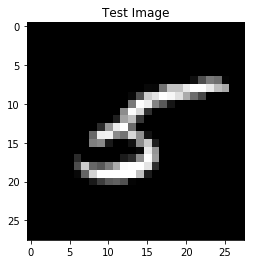

In [20]:
testx = np.where(np.prod(testHogProjected == t_img, axis = -1))
testy = testx[0][0]
testimg = testImages[testy]
title('Test Image')
gray()
imshow(testimg)
print()
print("Test Image...")


PCA's n_components:  10 

K:  5 

Result Images...


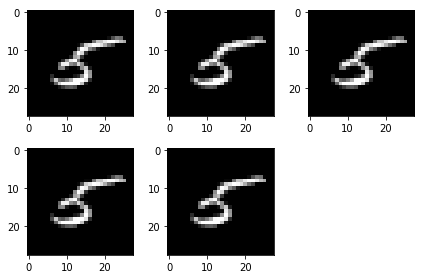

In [21]:
print()
print("PCA's n_components: ", pcaDim,"\n")
print("K: ", k,"\n")
print("Result Images...")
for i in range(k):
    res_img = trainingImages[result[i]]
    img_tr = PIL.Image.fromarray(res_img)
    subplot(int(k/2),k-int(k/2),i+1)
    gray()
    imshow(testimg)
    tight_layout()

In [24]:
k = 5 # Number of Search
Y_pred = []
s = 0 # store the number of correct predictions
t = 0 # store the number of samples located in the h.y.p with no points in it
for j in range(testDataSize):
    x = X_test[j]
    t_img = testHogProjected[j]
    print('The truth label:', j, testLabels[j])
    result = searchLSH(table, x, t_img, k, uniform_planes)
    knn = [0]*10
    if result:
        for i in range(len(result)):
            knn[trainingLabels[result[i]]] += 1
        Y_pred.append(knn.index(max(knn)))
    else:
        Y_pred.append(int(-1))
        t += 1
    print('The predicted label:', j, Y_pred[-1])
    if Y_pred[-1]==Y_test[j][0]:
        s+=1
print('CCR:', s/testDataSize)
print('Number of no prediction points:', t)

The truth label: 0 0
The predicted label: 0 0
The truth label: 1 0
The predicted label: 1 0
The truth label: 2 0
The predicted label: 2 0
The truth label: 3 0
The predicted label: 3 0
The truth label: 4 0
The predicted label: 4 0
The truth label: 5 0
The predicted label: 5 0
The truth label: 6 0
The predicted label: 6 0
The truth label: 7 0
The predicted label: 7 0
The truth label: 8 0
The predicted label: 8 0
The truth label: 9 0
The predicted label: 9 0
The truth label: 10 0
The predicted label: 10 0
The truth label: 11 0
The predicted label: 11 0
The truth label: 12 0
The predicted label: 12 0
The truth label: 13 0
The predicted label: 13 0
The truth label: 14 0
The predicted label: 14 0
The truth label: 15 0
The predicted label: 15 0
The truth label: 16 0
The predicted label: 16 0
The truth label: 17 0
The predicted label: 17 0
The truth label: 18 0
The predicted label: 18 0
The truth label: 19 0
The predicted label: 19 0
The truth label: 20 0
The predicted label: 20 0
The truth la

The truth label: 210 0
The predicted label: 210 0
The truth label: 211 0
The predicted label: 211 0
The truth label: 212 0
The predicted label: 212 0
The truth label: 213 0
The predicted label: 213 0
The truth label: 214 0
The predicted label: 214 0
The truth label: 215 0
The predicted label: 215 0
The truth label: 216 0
The predicted label: 216 0
The truth label: 217 0
The predicted label: 217 0
The truth label: 218 0
The predicted label: 218 0
The truth label: 219 0
The predicted label: 219 0
The truth label: 220 0
The predicted label: 220 0
The truth label: 221 0
The predicted label: 221 0
The truth label: 222 0
The predicted label: 222 0
The truth label: 223 0
The predicted label: 223 0
The truth label: 224 0
The predicted label: 224 0
The truth label: 225 0
The predicted label: 225 0
The truth label: 226 0
The predicted label: 226 0
The truth label: 227 0
The predicted label: 227 0
The truth label: 228 0
The predicted label: 228 0
The truth label: 229 0
The predicted label: 229 0


The truth label: 464 0
The predicted label: 464 0
The truth label: 465 0
The predicted label: 465 0
The truth label: 466 0
The predicted label: 466 0
The truth label: 467 0
The predicted label: 467 0
The truth label: 468 0
The predicted label: 468 0
The truth label: 469 0
The predicted label: 469 0
The truth label: 470 0
The predicted label: 470 0
The truth label: 471 0
The predicted label: 471 0
The truth label: 472 0
The predicted label: 472 0
The truth label: 473 0
The predicted label: 473 0
The truth label: 474 0
The predicted label: 474 0
The truth label: 475 0
The predicted label: 475 0
The truth label: 476 0
The predicted label: 476 0
The truth label: 477 0
The predicted label: 477 5
The truth label: 478 0
The predicted label: 478 0
The truth label: 479 0
The predicted label: 479 0
The truth label: 480 0
The predicted label: 480 0
The truth label: 481 0
The predicted label: 481 0
The truth label: 482 0
The predicted label: 482 0
The truth label: 483 0
The predicted label: 483 0


The predicted label: 628 0
The truth label: 629 0
The predicted label: 629 7
The truth label: 630 0
The predicted label: 630 0
The truth label: 631 0
The predicted label: 631 0
The truth label: 632 0
The predicted label: 632 0
The truth label: 633 0
The predicted label: 633 0
The truth label: 634 0
The predicted label: 634 8
The truth label: 635 0
The predicted label: 635 0
The truth label: 636 0
The predicted label: 636 0
The truth label: 637 0
The predicted label: 637 0
The truth label: 638 0
The predicted label: 638 0
The truth label: 639 0
The predicted label: 639 0
The truth label: 640 0
The predicted label: 640 0
The truth label: 641 0
The predicted label: 641 0
The truth label: 642 0
The predicted label: 642 0
The truth label: 643 0
The predicted label: 643 0
The truth label: 644 0
The predicted label: 644 0
The truth label: 645 0
The predicted label: 645 0
The truth label: 646 0
The predicted label: 646 0
The truth label: 647 0
The predicted label: 647 0
The truth label: 648 0


The predicted label: 796 0
The truth label: 797 0
The predicted label: 797 0
The truth label: 798 0
The predicted label: 798 0
The truth label: 799 0
The predicted label: 799 0
The truth label: 800 0
The predicted label: 800 0
The truth label: 801 0
The predicted label: 801 0
The truth label: 802 0
The predicted label: 802 0
The truth label: 803 0
The predicted label: 803 0
The truth label: 804 0
The predicted label: 804 0
The truth label: 805 0
The predicted label: 805 0
The truth label: 806 0
The predicted label: 806 0
The truth label: 807 0
The predicted label: 807 6
The truth label: 808 0
The predicted label: 808 0
The truth label: 809 0
The predicted label: 809 0
The truth label: 810 0
The predicted label: 810 0
The truth label: 811 0
The predicted label: 811 0
The truth label: 812 0
The predicted label: 812 0
The truth label: 813 0
The predicted label: 813 0
The truth label: 814 0
The predicted label: 814 0
The truth label: 815 0
The predicted label: 815 0
The truth label: 816 0


The predicted label: 1044 1
The truth label: 1045 1
The predicted label: 1045 1
The truth label: 1046 1
The predicted label: 1046 1
The truth label: 1047 1
The predicted label: 1047 1
The truth label: 1048 1
The predicted label: 1048 1
The truth label: 1049 1
The predicted label: 1049 1
The truth label: 1050 1
The predicted label: 1050 1
The truth label: 1051 1
The predicted label: 1051 1
The truth label: 1052 1
The predicted label: 1052 1
The truth label: 1053 1
The predicted label: 1053 1
The truth label: 1054 1
The predicted label: 1054 1
The truth label: 1055 1
The predicted label: 1055 1
The truth label: 1056 1
The predicted label: 1056 1
The truth label: 1057 1
The predicted label: 1057 1
The truth label: 1058 1
The predicted label: 1058 1
The truth label: 1059 1
The predicted label: 1059 1
The truth label: 1060 1
The predicted label: 1060 1
The truth label: 1061 1
The predicted label: 1061 1
The truth label: 1062 1
The predicted label: 1062 1
The truth label: 1063 1
The predicte

The truth label: 1252 1
The predicted label: 1252 1
The truth label: 1253 1
The predicted label: 1253 1
The truth label: 1254 1
The predicted label: 1254 2
The truth label: 1255 1
The predicted label: 1255 1
The truth label: 1256 1
The predicted label: 1256 1
The truth label: 1257 1
The predicted label: 1257 1
The truth label: 1258 1
The predicted label: 1258 1
The truth label: 1259 1
The predicted label: 1259 1
The truth label: 1260 1
The predicted label: 1260 1
The truth label: 1261 1
The predicted label: 1261 1
The truth label: 1262 1
The predicted label: 1262 1
The truth label: 1263 1
The predicted label: 1263 1
The truth label: 1264 1
The predicted label: 1264 1
The truth label: 1265 1
The predicted label: 1265 1
The truth label: 1266 1
The predicted label: 1266 1
The truth label: 1267 1
The predicted label: 1267 1
The truth label: 1268 1
The predicted label: 1268 1
The truth label: 1269 1
The predicted label: 1269 1
The truth label: 1270 1
The predicted label: 1270 1
The truth la

The predicted label: 1469 1
The truth label: 1470 1
The predicted label: 1470 1
The truth label: 1471 1
The predicted label: 1471 1
The truth label: 1472 1
The predicted label: 1472 1
The truth label: 1473 1
The predicted label: 1473 1
The truth label: 1474 1
The predicted label: 1474 1
The truth label: 1475 1
The predicted label: 1475 1
The truth label: 1476 1
The predicted label: 1476 1
The truth label: 1477 1
The predicted label: 1477 1
The truth label: 1478 1
The predicted label: 1478 1
The truth label: 1479 1
The predicted label: 1479 1
The truth label: 1480 1
The predicted label: 1480 1
The truth label: 1481 1
The predicted label: 1481 1
The truth label: 1482 1
The predicted label: 1482 1
The truth label: 1483 1
The predicted label: 1483 1
The truth label: 1484 1
The predicted label: 1484 1
The truth label: 1485 1
The predicted label: 1485 1
The truth label: 1486 1
The predicted label: 1486 1
The truth label: 1487 1
The predicted label: 1487 1
The truth label: 1488 1
The predicte

The predicted label: 1711 1
The truth label: 1712 1
The predicted label: 1712 1
The truth label: 1713 1
The predicted label: 1713 1
The truth label: 1714 1
The predicted label: 1714 1
The truth label: 1715 1
The predicted label: 1715 1
The truth label: 1716 1
The predicted label: 1716 1
The truth label: 1717 1
The predicted label: 1717 1
The truth label: 1718 1
The predicted label: 1718 1
The truth label: 1719 1
The predicted label: 1719 1
The truth label: 1720 1
The predicted label: 1720 1
The truth label: 1721 1
The predicted label: 1721 1
The truth label: 1722 1
The predicted label: 1722 1
The truth label: 1723 1
The predicted label: 1723 1
The truth label: 1724 1
The predicted label: 1724 1
The truth label: 1725 1
The predicted label: 1725 1
The truth label: 1726 1
The predicted label: 1726 1
The truth label: 1727 1
The predicted label: 1727 1
The truth label: 1728 1
The predicted label: 1728 1
The truth label: 1729 1
The predicted label: 1729 1
The truth label: 1730 1
The predicte

The predicted label: 1959 1
The truth label: 1960 1
The predicted label: 1960 1
The truth label: 1961 1
The predicted label: 1961 1
The truth label: 1962 1
The predicted label: 1962 1
The truth label: 1963 1
The predicted label: 1963 1
The truth label: 1964 1
The predicted label: 1964 1
The truth label: 1965 1
The predicted label: 1965 1
The truth label: 1966 1
The predicted label: 1966 1
The truth label: 1967 1
The predicted label: 1967 1
The truth label: 1968 1
The predicted label: 1968 1
The truth label: 1969 1
The predicted label: 1969 1
The truth label: 1970 1
The predicted label: 1970 1
The truth label: 1971 1
The predicted label: 1971 1
The truth label: 1972 1
The predicted label: 1972 1
The truth label: 1973 1
The predicted label: 1973 1
The truth label: 1974 1
The predicted label: 1974 1
The truth label: 1975 1
The predicted label: 1975 1
The truth label: 1976 1
The predicted label: 1976 1
The truth label: 1977 1
The predicted label: 1977 1
The truth label: 1978 1
The predicte

The predicted label: 2212 2
The truth label: 2213 2
The predicted label: 2213 2
The truth label: 2214 2
The predicted label: 2214 2
The truth label: 2215 2
The predicted label: 2215 2
The truth label: 2216 2
The predicted label: 2216 2
The truth label: 2217 2
The predicted label: 2217 2
The truth label: 2218 2
The predicted label: 2218 2
The truth label: 2219 2
The predicted label: 2219 2
The truth label: 2220 2
The predicted label: 2220 7
The truth label: 2221 2
The predicted label: 2221 2
The truth label: 2222 2
The predicted label: 2222 0
The truth label: 2223 2
The predicted label: 2223 2
The truth label: 2224 2
The predicted label: 2224 2
The truth label: 2225 2
The predicted label: 2225 2
The truth label: 2226 2
The predicted label: 2226 2
The truth label: 2227 2
The predicted label: 2227 2
The truth label: 2228 2
The predicted label: 2228 2
The truth label: 2229 2
The predicted label: 2229 2
The truth label: 2230 2
The predicted label: 2230 2
The truth label: 2231 2
The predicte

The truth label: 2459 2
The predicted label: 2459 2
The truth label: 2460 2
The predicted label: 2460 2
The truth label: 2461 2
The predicted label: 2461 2
The truth label: 2462 2
The predicted label: 2462 2
The truth label: 2463 2
The predicted label: 2463 2
The truth label: 2464 2
The predicted label: 2464 2
The truth label: 2465 2
The predicted label: 2465 2
The truth label: 2466 2
The predicted label: 2466 2
The truth label: 2467 2
The predicted label: 2467 2
The truth label: 2468 2
The predicted label: 2468 2
The truth label: 2469 2
The predicted label: 2469 2
The truth label: 2470 2
The predicted label: 2470 2
The truth label: 2471 2
The predicted label: 2471 2
The truth label: 2472 2
The predicted label: 2472 2
The truth label: 2473 2
The predicted label: 2473 2
The truth label: 2474 2
The predicted label: 2474 2
The truth label: 2475 2
The predicted label: 2475 2
The truth label: 2476 2
The predicted label: 2476 7
The truth label: 2477 2
The predicted label: 2477 2
The truth la

The truth label: 2617 2
The predicted label: 2617 2
The truth label: 2618 2
The predicted label: 2618 2
The truth label: 2619 2
The predicted label: 2619 2
The truth label: 2620 2
The predicted label: 2620 2
The truth label: 2621 2
The predicted label: 2621 2
The truth label: 2622 2
The predicted label: 2622 2
The truth label: 2623 2
The predicted label: 2623 2
The truth label: 2624 2
The predicted label: 2624 2
The truth label: 2625 2
The predicted label: 2625 3
The truth label: 2626 2
The predicted label: 2626 3
The truth label: 2627 2
The predicted label: 2627 2
The truth label: 2628 2
The predicted label: 2628 2
The truth label: 2629 2
The predicted label: 2629 2
The truth label: 2630 2
The predicted label: 2630 2
The truth label: 2631 2
The predicted label: 2631 2
The truth label: 2632 2
The predicted label: 2632 2
The truth label: 2633 2
The predicted label: 2633 2
The truth label: 2634 2
The predicted label: 2634 2
The truth label: 2635 2
The predicted label: 2635 2
The truth la

The truth label: 2817 2
The predicted label: 2817 2
The truth label: 2818 2
The predicted label: 2818 2
The truth label: 2819 2
The predicted label: 2819 2
The truth label: 2820 2
The predicted label: 2820 2
The truth label: 2821 2
The predicted label: 2821 2
The truth label: 2822 2
The predicted label: 2822 2
The truth label: 2823 2
The predicted label: 2823 2
The truth label: 2824 2
The predicted label: 2824 7
The truth label: 2825 2
No point in this hash.
The predicted label: 2825 -1
The truth label: 2826 2
The predicted label: 2826 2
The truth label: 2827 2
The predicted label: 2827 2
The truth label: 2828 2
The predicted label: 2828 2
The truth label: 2829 2
The predicted label: 2829 2
The truth label: 2830 2
The predicted label: 2830 2
The truth label: 2831 2
The predicted label: 2831 2
The truth label: 2832 2
The predicted label: 2832 2
The truth label: 2833 2
The predicted label: 2833 2
The truth label: 2834 2
The predicted label: 2834 2
The truth label: 2835 2
The predicted la

The truth label: 3124 2
The predicted label: 3124 0
The truth label: 3125 2
The predicted label: 3125 2
The truth label: 3126 2
The predicted label: 3126 2
The truth label: 3127 2
The predicted label: 3127 8
The truth label: 3128 2
The predicted label: 3128 2
The truth label: 3129 2
The predicted label: 3129 2
The truth label: 3130 2
The predicted label: 3130 7
The truth label: 3131 2
The predicted label: 3131 2
The truth label: 3132 2
The predicted label: 3132 2
The truth label: 3133 2
The predicted label: 3133 2
The truth label: 3134 2
The predicted label: 3134 8
The truth label: 3135 2
The predicted label: 3135 2
The truth label: 3136 2
The predicted label: 3136 2
The truth label: 3137 2
The predicted label: 3137 7
The truth label: 3138 2
The predicted label: 3138 3
The truth label: 3139 2
The predicted label: 3139 2
The truth label: 3140 2
The predicted label: 3140 2
The truth label: 3141 2
The predicted label: 3141 2
The truth label: 3142 2
The predicted label: 3142 2
The truth la

The predicted label: 3377 3
The truth label: 3378 3
The predicted label: 3378 3
The truth label: 3379 3
The predicted label: 3379 3
The truth label: 3380 3
The predicted label: 3380 3
The truth label: 3381 3
The predicted label: 3381 3
The truth label: 3382 3
The predicted label: 3382 3
The truth label: 3383 3
The predicted label: 3383 3
The truth label: 3384 3
The predicted label: 3384 3
The truth label: 3385 3
The predicted label: 3385 3
The truth label: 3386 3
The predicted label: 3386 3
The truth label: 3387 3
The predicted label: 3387 3
The truth label: 3388 3
The predicted label: 3388 3
The truth label: 3389 3
The predicted label: 3389 3
The truth label: 3390 3
The predicted label: 3390 3
The truth label: 3391 3
The predicted label: 3391 3
The truth label: 3392 3
The predicted label: 3392 3
The truth label: 3393 3
The predicted label: 3393 3
The truth label: 3394 3
The predicted label: 3394 3
The truth label: 3395 3
The predicted label: 3395 3
The truth label: 3396 3
The predicte

The predicted label: 3625 3
The truth label: 3626 3
The predicted label: 3626 8
The truth label: 3627 3
The predicted label: 3627 3
The truth label: 3628 3
The predicted label: 3628 3
The truth label: 3629 3
The predicted label: 3629 5
The truth label: 3630 3
The predicted label: 3630 3
The truth label: 3631 3
The predicted label: 3631 3
The truth label: 3632 3
The predicted label: 3632 3
The truth label: 3633 3
The predicted label: 3633 8
The truth label: 3634 3
The predicted label: 3634 3
The truth label: 3635 3
The predicted label: 3635 3
The truth label: 3636 3
The predicted label: 3636 3
The truth label: 3637 3
The predicted label: 3637 3
The truth label: 3638 3
The predicted label: 3638 3
The truth label: 3639 3
The predicted label: 3639 3
The truth label: 3640 3
The predicted label: 3640 3
The truth label: 3641 3
The predicted label: 3641 3
The truth label: 3642 3
The predicted label: 3642 3
The truth label: 3643 3
The predicted label: 3643 3
The truth label: 3644 3
The predicte

The predicted label: 3786 3
The truth label: 3787 3
The predicted label: 3787 2
The truth label: 3788 3
The predicted label: 3788 3
The truth label: 3789 3
The predicted label: 3789 3
The truth label: 3790 3
The predicted label: 3790 3
The truth label: 3791 3
The predicted label: 3791 3
The truth label: 3792 3
The predicted label: 3792 3
The truth label: 3793 3
The predicted label: 3793 3
The truth label: 3794 3
The predicted label: 3794 3
The truth label: 3795 3
The predicted label: 3795 3
The truth label: 3796 3
The predicted label: 3796 3
The truth label: 3797 3
The predicted label: 3797 3
The truth label: 3798 3
The predicted label: 3798 3
The truth label: 3799 3
The predicted label: 3799 3
The truth label: 3800 3
The predicted label: 3800 3
The truth label: 3801 3
The predicted label: 3801 3
The truth label: 3802 3
The predicted label: 3802 3
The truth label: 3803 3
The predicted label: 3803 3
The truth label: 3804 3
The predicted label: 3804 3
The truth label: 3805 3
The predicte

The predicted label: 3952 3
The truth label: 3953 3
The predicted label: 3953 3
The truth label: 3954 3
The predicted label: 3954 3
The truth label: 3955 3
The predicted label: 3955 3
The truth label: 3956 3
The predicted label: 3956 3
The truth label: 3957 3
The predicted label: 3957 3
The truth label: 3958 3
The predicted label: 3958 3
The truth label: 3959 3
The predicted label: 3959 3
The truth label: 3960 3
The predicted label: 3960 8
The truth label: 3961 3
The predicted label: 3961 3
The truth label: 3962 3
The predicted label: 3962 3
The truth label: 3963 3
The predicted label: 3963 3
The truth label: 3964 3
The predicted label: 3964 3
The truth label: 3965 3
The predicted label: 3965 3
The truth label: 3966 3
The predicted label: 3966 3
The truth label: 3967 3
The predicted label: 3967 3
The truth label: 3968 3
The predicted label: 3968 3
The truth label: 3969 3
The predicted label: 3969 3
The truth label: 3970 3
The predicted label: 3970 3
The truth label: 3971 3
The predicte

The predicted label: 4208 9
The truth label: 4209 4
The predicted label: 4209 8
The truth label: 4210 4
The predicted label: 4210 4
The truth label: 4211 4
The predicted label: 4211 4
The truth label: 4212 4
The predicted label: 4212 4
The truth label: 4213 4
The predicted label: 4213 4
The truth label: 4214 4
The predicted label: 4214 4
The truth label: 4215 4
The predicted label: 4215 4
The truth label: 4216 4
The predicted label: 4216 4
The truth label: 4217 4
The predicted label: 4217 4
The truth label: 4218 4
The predicted label: 4218 4
The truth label: 4219 4
The predicted label: 4219 4
The truth label: 4220 4
The predicted label: 4220 4
The truth label: 4221 4
The predicted label: 4221 9
The truth label: 4222 4
The predicted label: 4222 9
The truth label: 4223 4
The predicted label: 4223 4
The truth label: 4224 4
The predicted label: 4224 4
The truth label: 4225 4
The predicted label: 4225 4
The truth label: 4226 4
The predicted label: 4226 4
The truth label: 4227 4
The predicte

The predicted label: 4455 4
The truth label: 4456 4
The predicted label: 4456 4
The truth label: 4457 4
The predicted label: 4457 4
The truth label: 4458 4
The predicted label: 4458 4
The truth label: 4459 4
The predicted label: 4459 4
The truth label: 4460 4
The predicted label: 4460 4
The truth label: 4461 4
The predicted label: 4461 4
The truth label: 4462 4
The predicted label: 4462 4
The truth label: 4463 4
The predicted label: 4463 7
The truth label: 4464 4
The predicted label: 4464 4
The truth label: 4465 4
The predicted label: 4465 4
The truth label: 4466 4
The predicted label: 4466 4
The truth label: 4467 4
The predicted label: 4467 4
The truth label: 4468 4
The predicted label: 4468 4
The truth label: 4469 4
The predicted label: 4469 4
The truth label: 4470 4
The predicted label: 4470 4
The truth label: 4471 4
The predicted label: 4471 4
The truth label: 4472 4
The predicted label: 4472 4
The truth label: 4473 4
The predicted label: 4473 4
The truth label: 4474 4
The predicte

The truth label: 4666 4
The predicted label: 4666 4
The truth label: 4667 4
The predicted label: 4667 4
The truth label: 4668 4
The predicted label: 4668 4
The truth label: 4669 4
The predicted label: 4669 4
The truth label: 4670 4
The predicted label: 4670 4
The truth label: 4671 4
The predicted label: 4671 4
The truth label: 4672 4
The predicted label: 4672 4
The truth label: 4673 4
The predicted label: 4673 4
The truth label: 4674 4
The predicted label: 4674 4
The truth label: 4675 4
The predicted label: 4675 9
The truth label: 4676 4
The predicted label: 4676 4
The truth label: 4677 4
The predicted label: 4677 4
The truth label: 4678 4
The predicted label: 4678 4
The truth label: 4679 4
The predicted label: 4679 4
The truth label: 4680 4
The predicted label: 4680 4
The truth label: 4681 4
The predicted label: 4681 4
The truth label: 4682 4
The predicted label: 4682 4
The truth label: 4683 4
The predicted label: 4683 4
The truth label: 4684 4
The predicted label: 4684 4
The truth la

The predicted label: 4898 9
The truth label: 4899 4
The predicted label: 4899 4
The truth label: 4900 4
The predicted label: 4900 4
The truth label: 4901 4
The predicted label: 4901 8
The truth label: 4902 4
The predicted label: 4902 4
The truth label: 4903 4
The predicted label: 4903 4
The truth label: 4904 4
The predicted label: 4904 4
The truth label: 4905 4
The predicted label: 4905 4
The truth label: 4906 4
The predicted label: 4906 4
The truth label: 4907 4
The predicted label: 4907 4
The truth label: 4908 4
The predicted label: 4908 4
The truth label: 4909 4
The predicted label: 4909 4
The truth label: 4910 4
The predicted label: 4910 4
The truth label: 4911 4
The predicted label: 4911 4
The truth label: 4912 4
The predicted label: 4912 4
The truth label: 4913 4
The predicted label: 4913 4
The truth label: 4914 4
The predicted label: 4914 4
The truth label: 4915 4
The predicted label: 4915 4
The truth label: 4916 4
The predicted label: 4916 4
The truth label: 4917 4
The predicte

The predicted label: 5140 5
The truth label: 5141 5
The predicted label: 5141 5
The truth label: 5142 5
The predicted label: 5142 5
The truth label: 5143 5
The predicted label: 5143 5
The truth label: 5144 5
The predicted label: 5144 5
The truth label: 5145 5
The predicted label: 5145 5
The truth label: 5146 5
The predicted label: 5146 5
The truth label: 5147 5
The predicted label: 5147 5
The truth label: 5148 5
The predicted label: 5148 5
The truth label: 5149 5
The predicted label: 5149 5
The truth label: 5150 5
The predicted label: 5150 5
The truth label: 5151 5
The predicted label: 5151 5
The truth label: 5152 5
The predicted label: 5152 5
The truth label: 5153 5
The predicted label: 5153 5
The truth label: 5154 5
The predicted label: 5154 5
The truth label: 5155 5
The predicted label: 5155 5
The truth label: 5156 5
The predicted label: 5156 5
The truth label: 5157 5
The predicted label: 5157 5
The truth label: 5158 5
The predicted label: 5158 5
The truth label: 5159 5
The predicte

The predicted label: 5446 5
The truth label: 5447 5
The predicted label: 5447 5
The truth label: 5448 5
The predicted label: 5448 5
The truth label: 5449 5
The predicted label: 5449 5
The truth label: 5450 5
The predicted label: 5450 5
The truth label: 5451 5
The predicted label: 5451 5
The truth label: 5452 5
The predicted label: 5452 5
The truth label: 5453 5
The predicted label: 5453 5
The truth label: 5454 5
The predicted label: 5454 5
The truth label: 5455 5
The predicted label: 5455 5
The truth label: 5456 5
The predicted label: 5456 5
The truth label: 5457 5
The predicted label: 5457 5
The truth label: 5458 5
The predicted label: 5458 5
The truth label: 5459 5
The predicted label: 5459 5
The truth label: 5460 5
The predicted label: 5460 5
The truth label: 5461 5
The predicted label: 5461 5
The truth label: 5462 5
The predicted label: 5462 0
The truth label: 5463 5
The predicted label: 5463 3
The truth label: 5464 5
The predicted label: 5464 5
The truth label: 5465 5
The predicte

The predicted label: 5708 5
The truth label: 5709 5
The predicted label: 5709 5
The truth label: 5710 5
The predicted label: 5710 5
The truth label: 5711 5
The predicted label: 5711 5
The truth label: 5712 5
The predicted label: 5712 5
The truth label: 5713 5
The predicted label: 5713 5
The truth label: 5714 5
The predicted label: 5714 5
The truth label: 5715 5
The predicted label: 5715 5
The truth label: 5716 5
The predicted label: 5716 5
The truth label: 5717 5
The predicted label: 5717 5
The truth label: 5718 5
The predicted label: 5718 5
The truth label: 5719 5
The predicted label: 5719 5
The truth label: 5720 5
The predicted label: 5720 5
The truth label: 5721 5
The predicted label: 5721 5
The truth label: 5722 5
The predicted label: 5722 3
The truth label: 5723 5
The predicted label: 5723 3
The truth label: 5724 5
The predicted label: 5724 5
The truth label: 5725 5
The predicted label: 5725 5
The truth label: 5726 5
The predicted label: 5726 0
The truth label: 5727 5
The predicte

The truth label: 5872 5
The predicted label: 5872 5
The truth label: 5873 5
The predicted label: 5873 5
The truth label: 5874 5
The predicted label: 5874 5
The truth label: 5875 5
The predicted label: 5875 5
The truth label: 5876 5
The predicted label: 5876 5
The truth label: 5877 5
The predicted label: 5877 5
The truth label: 5878 5
The predicted label: 5878 5
The truth label: 5879 5
The predicted label: 5879 5
The truth label: 5880 5
The predicted label: 5880 5
The truth label: 5881 5
The predicted label: 5881 5
The truth label: 5882 5
The predicted label: 5882 5
The truth label: 5883 5
The predicted label: 5883 5
The truth label: 5884 5
The predicted label: 5884 5
The truth label: 5885 5
The predicted label: 5885 5
The truth label: 5886 5
The predicted label: 5886 5
The truth label: 5887 5
The predicted label: 5887 5
The truth label: 5888 5
The predicted label: 5888 5
The truth label: 5889 5
The predicted label: 5889 5
The truth label: 5890 5
The predicted label: 5890 5
The truth la

The truth label: 6119 6
The predicted label: 6119 6
The truth label: 6120 6
The predicted label: 6120 6
The truth label: 6121 6
The predicted label: 6121 8
The truth label: 6122 6
The predicted label: 6122 6
The truth label: 6123 6
The predicted label: 6123 6
The truth label: 6124 6
The predicted label: 6124 6
The truth label: 6125 6
The predicted label: 6125 6
The truth label: 6126 6
The predicted label: 6126 6
The truth label: 6127 6
The predicted label: 6127 6
The truth label: 6128 6
The predicted label: 6128 6
The truth label: 6129 6
The predicted label: 6129 6
The truth label: 6130 6
The predicted label: 6130 6
The truth label: 6131 6
The predicted label: 6131 6
The truth label: 6132 6
The predicted label: 6132 6
The truth label: 6133 6
The predicted label: 6133 5
The truth label: 6134 6
The predicted label: 6134 6
The truth label: 6135 6
The predicted label: 6135 6
The truth label: 6136 6
The predicted label: 6136 6
The truth label: 6137 6
The predicted label: 6137 6
The truth la

The truth label: 6370 6
The predicted label: 6370 6
The truth label: 6371 6
The predicted label: 6371 6
The truth label: 6372 6
The predicted label: 6372 6
The truth label: 6373 6
The predicted label: 6373 6
The truth label: 6374 6
The predicted label: 6374 6
The truth label: 6375 6
The predicted label: 6375 6
The truth label: 6376 6
The predicted label: 6376 6
The truth label: 6377 6
The predicted label: 6377 6
The truth label: 6378 6
The predicted label: 6378 6
The truth label: 6379 6
The predicted label: 6379 6
The truth label: 6380 6
The predicted label: 6380 6
The truth label: 6381 6
The predicted label: 6381 6
The truth label: 6382 6
The predicted label: 6382 6
The truth label: 6383 6
The predicted label: 6383 6
The truth label: 6384 6
The predicted label: 6384 6
The truth label: 6385 6
The predicted label: 6385 6
The truth label: 6386 6
The predicted label: 6386 6
The truth label: 6387 6
The predicted label: 6387 6
The truth label: 6388 6
The predicted label: 6388 6
The truth la

The predicted label: 6568 6
The truth label: 6569 6
The predicted label: 6569 6
The truth label: 6570 6
The predicted label: 6570 6
The truth label: 6571 6
The predicted label: 6571 6
The truth label: 6572 6
The predicted label: 6572 6
The truth label: 6573 6
The predicted label: 6573 6
The truth label: 6574 6
The predicted label: 6574 6
The truth label: 6575 6
The predicted label: 6575 6
The truth label: 6576 6
The predicted label: 6576 6
The truth label: 6577 6
The predicted label: 6577 6
The truth label: 6578 6
The predicted label: 6578 6
The truth label: 6579 6
The predicted label: 6579 6
The truth label: 6580 6
The predicted label: 6580 6
The truth label: 6581 6
The predicted label: 6581 6
The truth label: 6582 6
The predicted label: 6582 6
The truth label: 6583 6
The predicted label: 6583 6
The truth label: 6584 6
The predicted label: 6584 6
The truth label: 6585 6
The predicted label: 6585 6
The truth label: 6586 6
The predicted label: 6586 6
The truth label: 6587 6
The predicte

The predicted label: 6806 6
The truth label: 6807 6
The predicted label: 6807 6
The truth label: 6808 6
The predicted label: 6808 6
The truth label: 6809 6
The predicted label: 6809 6
The truth label: 6810 6
The predicted label: 6810 6
The truth label: 6811 6
The predicted label: 6811 6
The truth label: 6812 6
The predicted label: 6812 6
The truth label: 6813 6
The predicted label: 6813 6
The truth label: 6814 6
The predicted label: 6814 6
The truth label: 6815 6
The predicted label: 6815 6
The truth label: 6816 6
The predicted label: 6816 6
The truth label: 6817 6
The predicted label: 6817 6
The truth label: 6818 6
The predicted label: 6818 6
The truth label: 6819 6
The predicted label: 6819 6
The truth label: 6820 6
The predicted label: 6820 6
The truth label: 6821 6
The predicted label: 6821 6
The truth label: 6822 6
The predicted label: 6822 6
The truth label: 6823 6
The predicted label: 6823 6
The truth label: 6824 6
The predicted label: 6824 6
The truth label: 6825 6
The predicte

The predicted label: 7054 7
The truth label: 7055 7
The predicted label: 7055 7
The truth label: 7056 7
The predicted label: 7056 7
The truth label: 7057 7
The predicted label: 7057 4
The truth label: 7058 7
The predicted label: 7058 4
The truth label: 7059 7
The predicted label: 7059 7
The truth label: 7060 7
The predicted label: 7060 7
The truth label: 7061 7
The predicted label: 7061 7
The truth label: 7062 7
The predicted label: 7062 7
The truth label: 7063 7
The predicted label: 7063 7
The truth label: 7064 7
The predicted label: 7064 7
The truth label: 7065 7
The predicted label: 7065 7
The truth label: 7066 7
The predicted label: 7066 7
The truth label: 7067 7
The predicted label: 7067 2
The truth label: 7068 7
The predicted label: 7068 7
The truth label: 7069 7
The predicted label: 7069 7
The truth label: 7070 7
The predicted label: 7070 7
The truth label: 7071 7
The predicted label: 7071 7
The truth label: 7072 7
The predicted label: 7072 7
The truth label: 7073 7
The predicte

The predicted label: 7311 9
The truth label: 7312 7
The predicted label: 7312 7
The truth label: 7313 7
The predicted label: 7313 7
The truth label: 7314 7
The predicted label: 7314 7
The truth label: 7315 7
The predicted label: 7315 7
The truth label: 7316 7
The predicted label: 7316 2
The truth label: 7317 7
The predicted label: 7317 7
The truth label: 7318 7
The predicted label: 7318 7
The truth label: 7319 7
The predicted label: 7319 7
The truth label: 7320 7
The predicted label: 7320 3
The truth label: 7321 7
The predicted label: 7321 7
The truth label: 7322 7
The predicted label: 7322 7
The truth label: 7323 7
The predicted label: 7323 1
The truth label: 7324 7
The predicted label: 7324 7
The truth label: 7325 7
The predicted label: 7325 7
The truth label: 7326 7
The predicted label: 7326 7
The truth label: 7327 7
The predicted label: 7327 7
The truth label: 7328 7
The predicted label: 7328 7
The truth label: 7329 7
The predicted label: 7329 7
The truth label: 7330 7
The predicte

The predicted label: 7622 7
The truth label: 7623 7
The predicted label: 7623 7
The truth label: 7624 7
The predicted label: 7624 7
The truth label: 7625 7
The predicted label: 7625 7
The truth label: 7626 7
The predicted label: 7626 7
The truth label: 7627 7
The predicted label: 7627 7
The truth label: 7628 7
The predicted label: 7628 7
The truth label: 7629 7
The predicted label: 7629 7
The truth label: 7630 7
The predicted label: 7630 7
The truth label: 7631 7
The predicted label: 7631 7
The truth label: 7632 7
The predicted label: 7632 7
The truth label: 7633 7
The predicted label: 7633 7
The truth label: 7634 7
The predicted label: 7634 7
The truth label: 7635 7
The predicted label: 7635 7
The truth label: 7636 7
The predicted label: 7636 7
The truth label: 7637 7
The predicted label: 7637 5
The truth label: 7638 7
The predicted label: 7638 7
The truth label: 7639 7
The predicted label: 7639 7
The truth label: 7640 7
The predicted label: 7640 7
The truth label: 7641 7
The predicte

The predicted label: 7783 7
The truth label: 7784 7
The predicted label: 7784 7
The truth label: 7785 7
The predicted label: 7785 7
The truth label: 7786 7
The predicted label: 7786 7
The truth label: 7787 7
The predicted label: 7787 7
The truth label: 7788 7
The predicted label: 7788 7
The truth label: 7789 7
The predicted label: 7789 7
The truth label: 7790 7
The predicted label: 7790 7
The truth label: 7791 7
The predicted label: 7791 7
The truth label: 7792 7
The predicted label: 7792 7
The truth label: 7793 7
The predicted label: 7793 7
The truth label: 7794 7
The predicted label: 7794 7
The truth label: 7795 7
The predicted label: 7795 7
The truth label: 7796 7
The predicted label: 7796 7
The truth label: 7797 7
The predicted label: 7797 7
The truth label: 7798 7
The predicted label: 7798 7
The truth label: 7799 7
The predicted label: 7799 7
The truth label: 7800 7
The predicted label: 7800 7
The truth label: 7801 7
The predicted label: 7801 7
The truth label: 7802 7
The predicte

The truth label: 7944 7
The predicted label: 7944 7
The truth label: 7945 7
The predicted label: 7945 7
The truth label: 7946 7
The predicted label: 7946 7
The truth label: 7947 7
The predicted label: 7947 9
The truth label: 7948 7
The predicted label: 7948 7
The truth label: 7949 7
The predicted label: 7949 7
The truth label: 7950 7
The predicted label: 7950 7
The truth label: 7951 7
The predicted label: 7951 7
The truth label: 7952 7
The predicted label: 7952 7
The truth label: 7953 7
The predicted label: 7953 7
The truth label: 7954 7
The predicted label: 7954 7
The truth label: 7955 7
The predicted label: 7955 7
The truth label: 7956 7
The predicted label: 7956 7
The truth label: 7957 7
The predicted label: 7957 7
The truth label: 7958 7
The predicted label: 7958 7
The truth label: 7959 7
The predicted label: 7959 7
The truth label: 7960 7
The predicted label: 7960 7
The truth label: 7961 7
The predicted label: 7961 7
The truth label: 7962 7
The predicted label: 7962 7
The truth la

The truth label: 8203 8
The predicted label: 8203 8
The truth label: 8204 8
The predicted label: 8204 2
The truth label: 8205 8
The predicted label: 8205 8
The truth label: 8206 8
The predicted label: 8206 8
The truth label: 8207 8
The predicted label: 8207 8
The truth label: 8208 8
The predicted label: 8208 8
The truth label: 8209 8
The predicted label: 8209 3
The truth label: 8210 8
The predicted label: 8210 8
The truth label: 8211 8
The predicted label: 8211 8
The truth label: 8212 8
The predicted label: 8212 2
The truth label: 8213 8
The predicted label: 8213 8
The truth label: 8214 8
The predicted label: 8214 8
The truth label: 8215 8
The predicted label: 8215 8
The truth label: 8216 8
The predicted label: 8216 5
The truth label: 8217 8
The predicted label: 8217 8
The truth label: 8218 8
The predicted label: 8218 8
The truth label: 8219 8
The predicted label: 8219 8
The truth label: 8220 8
The predicted label: 8220 8
The truth label: 8221 8
The predicted label: 8221 8
The truth la

The predicted label: 8363 8
The truth label: 8364 8
The predicted label: 8364 8
The truth label: 8365 8
The predicted label: 8365 8
The truth label: 8366 8
The predicted label: 8366 0
The truth label: 8367 8
The predicted label: 8367 8
The truth label: 8368 8
The predicted label: 8368 8
The truth label: 8369 8
The predicted label: 8369 8
The truth label: 8370 8
The predicted label: 8370 8
The truth label: 8371 8
The predicted label: 8371 8
The truth label: 8372 8
The predicted label: 8372 3
The truth label: 8373 8
The predicted label: 8373 8
The truth label: 8374 8
The predicted label: 8374 8
The truth label: 8375 8
The predicted label: 8375 5
The truth label: 8376 8
The predicted label: 8376 9
The truth label: 8377 8
The predicted label: 8377 8
The truth label: 8378 8
The predicted label: 8378 3
The truth label: 8379 8
The predicted label: 8379 8
The truth label: 8380 8
The predicted label: 8380 8
The truth label: 8381 8
The predicted label: 8381 8
The truth label: 8382 8
The predicte

The truth label: 8534 8
The predicted label: 8534 8
The truth label: 8535 8
The predicted label: 8535 8
The truth label: 8536 8
The predicted label: 8536 1
The truth label: 8537 8
The predicted label: 8537 8
The truth label: 8538 8
The predicted label: 8538 8
The truth label: 8539 8
The predicted label: 8539 8
The truth label: 8540 8
The predicted label: 8540 8
The truth label: 8541 8
The predicted label: 8541 8
The truth label: 8542 8
The predicted label: 8542 8
The truth label: 8543 8
The predicted label: 8543 8
The truth label: 8544 8
The predicted label: 8544 9
The truth label: 8545 8
The predicted label: 8545 8
The truth label: 8546 8
The predicted label: 8546 8
The truth label: 8547 8
The predicted label: 8547 8
The truth label: 8548 8
The predicted label: 8548 8
The truth label: 8549 8
The predicted label: 8549 8
The truth label: 8550 8
The predicted label: 8550 8
The truth label: 8551 8
The predicted label: 8551 8
The truth label: 8552 8
The predicted label: 8552 8
The truth la

The predicted label: 8694 8
The truth label: 8695 8
The predicted label: 8695 8
The truth label: 8696 8
The predicted label: 8696 8
The truth label: 8697 8
The predicted label: 8697 8
The truth label: 8698 8
The predicted label: 8698 8
The truth label: 8699 8
The predicted label: 8699 8
The truth label: 8700 8
The predicted label: 8700 8
The truth label: 8701 8
The predicted label: 8701 8
The truth label: 8702 8
The predicted label: 8702 8
The truth label: 8703 8
The predicted label: 8703 8
The truth label: 8704 8
The predicted label: 8704 3
The truth label: 8705 8
The predicted label: 8705 8
The truth label: 8706 8
The predicted label: 8706 8
The truth label: 8707 8
The predicted label: 8707 8
The truth label: 8708 8
The predicted label: 8708 8
The truth label: 8709 8
The predicted label: 8709 8
The truth label: 8710 8
The predicted label: 8710 8
The truth label: 8711 8
The predicted label: 8711 8
The truth label: 8712 8
The predicted label: 8712 8
The truth label: 8713 8
The predicte

The truth label: 8952 8
The predicted label: 8952 8
The truth label: 8953 8
The predicted label: 8953 8
The truth label: 8954 8
The predicted label: 8954 2
The truth label: 8955 8
The predicted label: 8955 8
The truth label: 8956 8
The predicted label: 8956 7
The truth label: 8957 8
The predicted label: 8957 8
The truth label: 8958 8
The predicted label: 8958 8
The truth label: 8959 8
The predicted label: 8959 8
The truth label: 8960 8
The predicted label: 8960 8
The truth label: 8961 8
The predicted label: 8961 8
The truth label: 8962 8
The predicted label: 8962 8
The truth label: 8963 8
The predicted label: 8963 8
The truth label: 8964 8
The predicted label: 8964 8
The truth label: 8965 8
The predicted label: 8965 8
The truth label: 8966 8
The predicted label: 8966 8
The truth label: 8967 8
No point in this hash.
The predicted label: 8967 -1
The truth label: 8968 8
The predicted label: 8968 8
The truth label: 8969 8
The predicted label: 8969 8
The truth label: 8970 8
The predicted la

The truth label: 9203 9
The predicted label: 9203 9
The truth label: 9204 9
The predicted label: 9204 9
The truth label: 9205 9
The predicted label: 9205 9
The truth label: 9206 9
The predicted label: 9206 4
The truth label: 9207 9
The predicted label: 9207 9
The truth label: 9208 9
The predicted label: 9208 9
The truth label: 9209 9
The predicted label: 9209 9
The truth label: 9210 9
The predicted label: 9210 8
The truth label: 9211 9
The predicted label: 9211 9
The truth label: 9212 9
The predicted label: 9212 4
The truth label: 9213 9
The predicted label: 9213 9
The truth label: 9214 9
The predicted label: 9214 9
The truth label: 9215 9
The predicted label: 9215 9
The truth label: 9216 9
The predicted label: 9216 9
The truth label: 9217 9
The predicted label: 9217 9
The truth label: 9218 9
The predicted label: 9218 4
The truth label: 9219 9
The predicted label: 9219 0
The truth label: 9220 9
The predicted label: 9220 1
The truth label: 9221 9
The predicted label: 9221 4
The truth la

The predicted label: 9454 4
The truth label: 9455 9
The predicted label: 9455 4
The truth label: 9456 9
The predicted label: 9456 9
The truth label: 9457 9
The predicted label: 9457 9
The truth label: 9458 9
The predicted label: 9458 9
The truth label: 9459 9
The predicted label: 9459 9
The truth label: 9460 9
The predicted label: 9460 9
The truth label: 9461 9
The predicted label: 9461 9
The truth label: 9462 9
The predicted label: 9462 9
The truth label: 9463 9
The predicted label: 9463 9
The truth label: 9464 9
The predicted label: 9464 9
The truth label: 9465 9
The predicted label: 9465 9
The truth label: 9466 9
The predicted label: 9466 9
The truth label: 9467 9
The predicted label: 9467 9
The truth label: 9468 9
The predicted label: 9468 9
The truth label: 9469 9
The predicted label: 9469 9
The truth label: 9470 9
The predicted label: 9470 9
The truth label: 9471 9
The predicted label: 9471 9
The truth label: 9472 9
The predicted label: 9472 4
The truth label: 9473 9
The predicte

The predicted label: 9705 9
The truth label: 9706 9
The predicted label: 9706 9
The truth label: 9707 9
The predicted label: 9707 9
The truth label: 9708 9
The predicted label: 9708 9
The truth label: 9709 9
The predicted label: 9709 9
The truth label: 9710 9
The predicted label: 9710 9
The truth label: 9711 9
The predicted label: 9711 9
The truth label: 9712 9
The predicted label: 9712 9
The truth label: 9713 9
The predicted label: 9713 9
The truth label: 9714 9
The predicted label: 9714 9
The truth label: 9715 9
The predicted label: 9715 4
The truth label: 9716 9
The predicted label: 9716 9
The truth label: 9717 9
The predicted label: 9717 9
The truth label: 9718 9
The predicted label: 9718 9
The truth label: 9719 9
The predicted label: 9719 9
The truth label: 9720 9
The predicted label: 9720 9
The truth label: 9721 9
The predicted label: 9721 9
The truth label: 9722 9
The predicted label: 9722 9
The truth label: 9723 9
The predicted label: 9723 9
The truth label: 9724 9
The predicte

In [51]:
# try different number of planes
print("Generate a uniform plane and get the hashes..."), 
tik = currentTime() 
n_planes = 10
hash_size = 11
Y_pred_all = []
for n in range(n_planes):
    tik = currentTime()
    input_dim = imageSize*imageSize
    num_hashtables = 1
    #  train
    hashtable = {}
    uniform_planes = np.random.randn(hash_size, input_dim)
    print(n, uniform_planes)
    for j, x in enumerate(X_train):
        hashstr = compute_hash(x, uniform_planes)
        #print(hashstr)
        hexhash =  hex(int(hashstr, 2))
        if hexhash in hashtable:
            hashtable[hexhash].append(j)
        else:
            hashtable[hexhash] = [j]
    
    # test
    Y_pred = []
    k = 5 # Number of Search
    s = 0 # store the number of correct predictions
    t = 0 # store the number of samples located in the h.y.p with no points in it
    for j in range(testDataSize):
        x = X_test[j]
        t_img = testHogProjected[j]
        #print('The truth label:', j, testLabels[j])
        result = searchLSH(table, x, t_img, k, uniform_planes)
        knn = [0]*10
        if result:
            for i in range(len(result)):
                knn[trainingLabels[result[i]]] += 1
            Y_pred.append(knn.index(max(knn)))
        else:
            Y_pred.append(int(-1))
            t += 1
        #print('The predicted label:', j, Y_pred[-1])
        if Y_pred[-1]==Y_test[j][0]:
            s+=1
    print('CCR with hash size =', hash_size, 'is', s/testDataSize)
    print('Number of no prediction points:', t)
    print('Running time: '+str(currentTime() - tik)+'secs')
    Y_pred_all.append(Y_pred)

s = 0
for i in range(testDataSize):
    lst = [Y_pred_all[j][i] for j in range(n_planes)]
    maxkey = None
    c = collections.Counter(lst)
    #print(c)
    for key in c:
        if not maxkey:
            maxkey = key
        else:
            if c[maxkey] < c[key]:
                maxkey = key
    #print(maxkey)
    if maxkey == Y_test[i][0]:
        s+=1
print('Total CCR with hash size =', hash_size, 'is', s/testDataSize)

Generate a uniform plane and get the hashes...
0 [[ -3.54156542e-01  -1.76050922e+00  -8.95987427e-01 ...,  -9.92527073e-01
   -2.63084136e-01  -2.90435282e-01]
 [  2.44892448e-02  -7.07854258e-02  -6.43367045e-02 ...,   2.10209014e-01
    2.00327379e+00  -9.06858307e-01]
 [  8.25619188e-01  -1.02398985e-01  -7.41889977e-01 ...,  -1.43938419e+00
   -6.57829442e-01   2.20858166e-01]
 ..., 
 [  6.27583866e-01  -8.92449430e-01   2.29151633e+00 ...,  -9.10739653e-02
    3.35038698e-01  -7.49812443e-01]
 [  4.90674564e-01  -9.41642374e-02  -2.26294297e-01 ...,   2.99451971e-05
    2.51394149e-01   1.68447051e+00]
 [  9.68339491e-03   7.31943873e-02   7.72183770e-01 ...,  -1.19669992e-01
   -9.72228047e-01   5.81006519e-01]]
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this h

No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
CCR with hash size = 11 is 0.9286
Number of no prediction points: 16
Running time: 119secs
9 [[-0.78875205 -0.68080697  0.59711154 ..., -0.16178593  1.08790183
   0.22744427]
 [-0.45580264 -0.93802077  0.62650856 ...,  1.03542197  0.26814082
  -1.29367284]
 [ 1.4559326  -0.5944199  -1.7682264  ..., -0.83305539 -0.77753128
   0.26002901]
 ..., 
 [-2.32185521 -1.95359648  0.94704661 ..., -1.6274436  -0.06547085
   0.07945234]
 [ 0.17700375 -0.82002034 -0.20377573 ..., -1.24164679 -0.70913282
   0.16678954]
 [ 0.07410374 -2.58116942 -0.87225745 ...,  0.24070823  0.21534768
  -0.01413252]]
No point in this hash.
No point in this

In [52]:
s = 0
for i in range(testDataSize):
    lst = [Y_pred_all[j][i] for j in range(n_planes)]
    maxkey = None
    c = collections.Counter(lst)
    #print(c)
    for key in c:
        if not maxkey:
            maxkey = key
        else:
            if c[maxkey] < c[key]:
                maxkey = key
    #print(maxkey)
    if maxkey == Y_test[i][0]:
        s+=1
print('Total CCR with hash size =', hash_size, 'is', s/testDataSize)

Total CCR with hash size = 11 is 0.9505


In [63]:
s = 0
for i in range(testDataSize):
    lst = [Y_pred_all[j][i] for j in range(n_planes)]
    maxkey = None
    c = collections.Counter(lst)
    #print(c)
    for key in c:
        if not maxkey:
            maxkey = key
        else:
            if c[maxkey] < c[key]:
                maxkey = key
    #print(maxkey)
    if maxkey == Y_test[i][0]:
        s+=1
print('Total CCR with hash size =', hash_size, 'is', s/testDataSize)

Total CCR with hash size = 11 is 0.9505


In [64]:
# try different number of hash size
print("Generate a uniform plane and get the hashes..."), 
tik = currentTime() 

for hash_size in range(6, 16):
    tik = currentTime()
    input_dim = imageSize*imageSize
    num_hashtables = 1
    #  train
    hashtable = {}
    uniform_planes = np.random.randn(hash_size, input_dim)
    print(hash_size, uniform_planes)
    for j, x in enumerate(X_train):
        hashstr = compute_hash(x, uniform_planes)
        #print(hashstr)
        hexhash =  hex(int(hashstr, 2))
        if hexhash in hashtable:
            hashtable[hexhash].append(j)
        else:
            hashtable[hexhash] = [j]
    
    # test
    k = 5 # Number of Search
    Y_pred = []
    s = 0 # store the number of correct predictions
    t = 0 # store the number of samples located in the h.y.p with no points in it
    for j in range(testDataSize):
        x = X_test[j]
        t_img = testHogProjected[j]
        #print('The truth label:', j, testLabels[j])
        result = searchLSH(table, x, t_img, k, uniform_planes)
        knn = [0]*10
        if result:
            for i in range(len(result)):
                knn[trainingLabels[result[i]]] += 1
            Y_pred.append(knn.index(max(knn)))
        else:
            Y_pred.append(int(-1))
            t += 1
        #print('The predicted label:', j, Y_pred[-1])
        if Y_pred[-1]==Y_test[j][0]:
            s+=1
    print('CCR with hash size =', hash_size, 'is', s/testDataSize)
    print('Number of no prediction points:', t)
    print('Running time: '+str(currentTime() - tik)+'secs.')


Generate a uniform plane and get the hashes...
6 [[ 1.17345396 -0.09026622  0.92147179 ..., -0.29668475  2.53051551
  -1.23021035]
 [ 0.15308262  0.91536191 -1.55658591 ...,  0.16234341  1.94337774
  -0.17825188]
 [ 1.11367045  0.35284057 -0.32036856 ..., -0.52683787 -1.12431714
  -1.62099115]
 [ 1.24675379  0.66321514 -0.39561573 ...,  0.16857539  0.61274667
   0.14816847]
 [-1.20328898  2.03881433 -0.34684831 ..., -0.39740853  1.07304134
   1.4932766 ]
 [ 1.49195335  1.65276804 -0.1208098  ...,  0.39727447 -0.9882614
   0.48364293]]
CCR with hash size = 6 is 0.9551
Number of no prediction points: 0
Running time: 446secs.
7 [[ 2.28086893 -2.37993047  0.39840003 ...,  1.69944397  0.87086193
  -0.71865337]
 [-0.29563896  1.14139503  1.14864109 ...,  1.53349964 -1.89764986
   1.86650249]
 [-0.87092703  0.22323746  0.16719294 ..., -0.82621475  2.38283958
   1.1753325 ]
 ..., 
 [ 1.07397246  0.47238577 -0.18336612 ...,  0.17148924  0.45625523
  -1.70523315]
 [-1.03372896 -0.67034454  0.834

No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in

No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in this hash.
No point in